# Time Series Forcasting w/ Python

## Content
- Time series analysis
    - ACF plot
    - PACF plot
    - Time seriees decomposition
- Statistical tests
    - ADF test - Test for stationarity
    - Ljung-Box test - Residuals analysis
    - Granger causality - Multivariate forecasting
- Forcasting - Statistical models
    - Moving average model - MA(q)
    - Autoregressive model - AR(q)
    - ARMA(p,q)
    - ARIMA(p,d,q)
    - SARIMA(p,d,q)(P,D,Q)$_m$
    - SARIMAX
    - VARMAX
    - BATS and TBATS
    - Exponential smoothing
- Forcasting - Deep learning models
    - Deep neural network (DNN)
    - Long short-term memory - LSTM
    - Convolutional neural network - CNN
    - Autoregressive deep learning model

## Time series analysis

### ACF plot

The autocorrelation function (ACF) plot shows the autocorrelation coefficients as a function of the lag.

Example use case:
- Use it to determine the order q of a stationary MA(q) process
- A stationary MA(q) process has significant coefficients up until lag q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Parameters
n = 500     # Number of observations
q = 3       # MA order

# Generate white noise
white_noise = np.random.standard_normal(n)

# Define MA coefficients
thetas = np.array([1]+list(range(2,2+q)))

# Generate MA(q) time series
ma_series = np.array([
    sum(white_noise[i - j] * thetas[j] for j in range(q+1) if i - j >= 0)
    for i in range(n)
])

# Plot the autocorrelation function (ACF)
plt.figure(figsize=(10, 4))
plot_acf(ma_series, lags=40)
plt.title(f"Autocorrelation Function of MA({q}) Process")
plt.tight_layout()
plt.show()


### PACF plot

The partial autocorrelation function (PACF) plot shows the partial autocorrelation coefficients as a function of the lag.

Example use case:
- Use it to determine the order p of a stationary AR(p) process
- A stationary AR(p) process has significant coefficients up until lag p

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Parameters
n = 500     # Number of observations
p = 3       # AR order

# Generate white noise
white_noise = np.random.standard_normal(n)

# Define AR coefficients
def generate_stable_polynomial(p, radius_min=0.5, radius_max=0.95):
    """
    Generate a polynomial of degree p with all roots inside the unit circle (|z| < 1).
    This ensures no root lies on |z| = 1.
    
    Parameters:
        p (int): Order of the polynomial
        radius_min (float): Minimum modulus of roots (to avoid very small values)
        radius_max (float): Maximum modulus of roots (< 1 to avoid unit circle)

    Returns:
        coeffs (np.ndarray): Polynomial coefficients
        roots (np.ndarray): Roots of the polynomial
    """
    # Generate random complex roots inside the unit circle (|z| < 1)
    angles = np.random.uniform(0, 2 * np.pi, p)
    radii = np.random.uniform(radius_min, radius_max, p)
    roots = radii * np.exp(1j * angles)

    # Get polynomial coefficients from roots
    coeffs = np.poly(roots).real  # Use .real to discard negligible imaginary part due to numerical error

    return coeffs, roots

p = 5
coeffs, roots = generate_stable_polynomial(p)

phis = coeffs

# Initialize time series with zeros (extra p values for warm-up)
ar_series = np.zeros(n)

# Generate AR(p) time series
for i in range(n):
    ar_series[i] = white_noise[i] + sum(ar_series[i - j] * phis[j] if i - j >= 0 else 0 for j in range(p))

# Plot the partial autocorrelation function (PACF)
plt.figure(figsize=(10, 4))
plot_pacf(ar_series)
plt.title(f"Partial Autocorrelation Function of AR({p}) Process")
plt.tight_layout()
plt.show()


### Time series decomposition
Separate the series into 3 components: trend, seasonality, and residuals
- Trend: long-term changes in the series
- Seasonality: periodical variations in the series
- Residuals: what is not explained by trend and seasonality

In [ ]:
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# m is the frequency of data (i.e., how many observations per season)
m = 5

n = 500

t = np.arange(1, n + 1)

# Generate series
white_noise = np.random.standard_normal(n)
trend = 1 + 0.05 * t
seasonal = 2 * np.cos(np.pi * t / 5) + 3 * np.sin(np.pi * t / 3)

series = trend + seasonal + white_noise

# Perform STL decomposition
decomp = STL(series, period=m).fit()

# Plot the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(decomp.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomp.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomp.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomp.resid)
ax4.set_ylabel('Residuals')

plt.xlabel('Time')
plt.tight_layout()
plt.show()


## Statistical tests

### ADF test – Test for stationarity
A series is stationary it its **mean**, **variance**, and **autocorrelation** are constant over time. Test for stationarity with augmented Dickey-Fuller (ADF) test.
- Null hypothesis: a unit root is present (i.e., the series is not stationary)
- We want a p-value < 0.05

> Notes: 

> The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
root, with the alternative that there is no unit root. If the pvalue is
above a critical size, then we cannot reject that there is a unit root.

> The p-values are obtained through regression surface approximation from
MacKinnon 1994, but using the updated 2010 tables. If the p-value is close
to significant, then the critical values should be used to judge whether
to reject the null.

> The autolag option and maxlag for it are described in Greene.

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

# m is the frequency of data (i.e., how many observations per season)
m = 5

n = 500

t = np.arange(1, n + 1)

# Generate series
white_noise = np.random.standard_normal(n)
trend = 1 + 0.05 * t
seasonal = 2 * np.cos(np.pi * t / 5) + 3 * np.sin(np.pi * t / 3)

series = trend + seasonal + white_noise


adf_test_stat, pvalue, usedlag, nobs, crit_val, icbest = adfuller(series)
print(f"adf_test_stat: {adf_test_stat}, \
      \n pvalue: {pvalue}, \
      \n usedlag: {usedlag}, \
      \n nobs: {nobs}, \
      \n crit_val: {crit_val}, \
      \n icbest: {icbest}")

if pvalue < .05:
      print('We have a stationary process')
else: 
      print('We have a non-stationary process')

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Parameters
n = 500     # Number of observations
q = 3       # MA order

# Generate white noise
white_noise = np.random.standard_normal(n)

# Define MA coefficients (e.g., θ1=2.0, θ2=3.0, θ3=4.0)
thetas = np.array([1]+list(range(2,2+q)))

# Generate MA(q) time series
ma_series = np.array([
    sum(white_noise[i - j] * thetas[j] for j in range(q+1) if i - j >= 0)
    for i in range(n)
])


adf_test_stat, pvalue, usedlag, nobs, crit_val, icbest = adfuller(ma_series)
print(f"adf_test_stat: {adf_test_stat}, \
      \n pvalue: {pvalue}, \
      \n usedlag: {usedlag}, \
      \n nobs: {nobs}, \
      \n crit_val: {crit_val}, \
      \n icbest: {icbest}")

if pvalue < .05:
      print('We have a stationary process')
else: 
      print('We have a non-stationary process')

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import adfuller


# Parameters
n = 500     # Number of observations
p = 3       # AR order

# Generate white noise
white_noise = np.random.standard_normal(n)

# Define AR coefficients
def generate_stable_polynomial(p, radius_min=0.5, radius_max=0.95):
    """
    Generate a polynomial of degree p with all roots inside the unit circle (|z| < 1).
    This ensures no root lies on |z| = 1.
    
    Parameters:
        p (int): Order of the polynomial
        radius_min (float): Minimum modulus of roots (to avoid very small values)
        radius_max (float): Maximum modulus of roots (< 1 to avoid unit circle)

    Returns:
        coeffs (np.ndarray): Polynomial coefficients
        roots (np.ndarray): Roots of the polynomial
    """
    # Generate random complex roots inside the unit circle (|z| < 1)
    angles = np.random.uniform(0, 2 * np.pi, p)
    radii = np.random.uniform(radius_min, radius_max, p)
    roots = radii * np.exp(1j * angles)

    # Get polynomial coefficients from roots
    coeffs = np.poly(roots).real  # Use .real to discard negligible imaginary part due to numerical error

    return coeffs, roots

p = 5
coeffs, roots = generate_stable_polynomial(p)

phis = coeffs

# Initialize time series with zeros (extra p values for warm-up)
ar_series = np.zeros(n)

# Generate AR(p) time series
for i in range(n):
    ar_series[i] = white_noise[i] + sum(ar_series[i - j] * phis[j] if i - j >= 0 else 0 for j in range(p))

adf_test_stat, pvalue, usedlag, nobs, crit_val, icbest = adfuller(ar_series)
print(f"adf_test_stat: {adf_test_stat}, \
      \n pvalue: {pvalue}, \
      \n usedlag: {usedlag}, \
      \n nobs: {nobs}, \
      \n crit_val: {crit_val}, \
      \n icbest: {icbest}")

if pvalue < .05:
      print('We have a stationary process')
else: 
      print('We have a non-stationary process')



Note: to make a series stationary, use differencing.
- n = 1: difference between consecutive timesteps
- n = 4: difference between values 4 timesteps apart
Differencing removes n data points.

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

# m is the frequency of data (i.e., how many observations per season)
m = 5

n = 500

t = np.arange(1, n + 1)

# Generate series
white_noise = np.random.standard_normal(n)
trend = 1 + 0.05 * t
seasonal = 2 * np.cos(np.pi * t / 5) + 3 * np.sin(np.pi * t / 3)

series = trend + seasonal + white_noise

diff_1_series = np.diff(series, n=1)
diff_4_series = np.diff(series, n=4)

adf_test_stat, pvalue, usedlag, nobs, crit_val, icbest = adfuller(diff_1_series)
print(f"diff_1_series\
      \n adf_test_stat: {adf_test_stat}, \
      \n pvalue: {pvalue}, \
      \n usedlag: {usedlag}, \
      \n nobs: {nobs}, \
      \n crit_val: {crit_val}, \
      \n icbest: {icbest}")

if pvalue < .05:
      print('We have a stationary process')
else: 
      print('We have a non-stationary process')


adf_test_stat, pvalue, usedlag, nobs, crit_val, icbest = adfuller(diff_4_series)
print(f"\n diff_4_series\
      \n adf_test_stat: {adf_test_stat}, \
      \n pvalue: {pvalue}, \
      \n usedlag: {usedlag}, \
      \n nobs: {nobs}, \
      \n crit_val: {crit_val}, \
      \n icbest: {icbest}")

if pvalue < .05:
      print('We have a stationary process')
else: 
      print('We have a non-stationary process')

### Ljung-Box test – Residuals analysis
Used to determine if the autocorrelation of a group of data is significantly different from 0. Use it on the residuals to check if they are independent.
- Null hypothesis: the data is independently distributed (i.e., there is no autocorrelation)
- We want a p-value > 0.05

In [ ]:
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa import arima

# Parameters
n = 500  # Number of observations

# Generate white noise
white_noise = np.random.standard_normal(n)

res = arima.model.ARIMA(white_noise).fit()

# Ljung-Box test
results = acorr_ljungbox(res.resid, lags=[10], return_df=True)

# Interpretation
if results['lb_pvalue'].iloc[-1] > 0.05:
    print("The data appears to be independently distributed (no significant autocorrelation).")
else:
    print("Evidence of autocorrelation found (reject H0 at 5% level).")


In [ ]:
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox


# Parameters
n = 500     # Number of observations
p = 3       # AR order

# Generate white noise
white_noise = np.random.standard_normal(n)

# Define AR coefficients
def generate_stable_polynomial(p, radius_min=0.5, radius_max=0.95):
    """
    Generate a polynomial of degree p with all roots inside the unit circle (|z| < 1).
    This ensures no root lies on |z| = 1.
    
    Parameters:
        p (int): Order of the polynomial
        radius_min (float): Minimum modulus of roots (to avoid very small values)
        radius_max (float): Maximum modulus of roots (< 1 to avoid unit circle)

    Returns:
        coeffs (np.ndarray): Polynomial coefficients
        roots (np.ndarray): Roots of the polynomial
    """
    # Generate random complex roots inside the unit circle (|z| < 1)
    angles = np.random.uniform(0, 2 * np.pi, p)
    radii = np.random.uniform(radius_min, radius_max, p)
    roots = radii * np.exp(1j * angles)

    # Get polynomial coefficients from roots
    coeffs = np.poly(roots).real  # Use .real to discard negligible imaginary part due to numerical error

    return coeffs, roots

p = 5
coeffs, roots = generate_stable_polynomial(p)

phis = coeffs

# Initialize time series with zeros (extra p values for warm-up)
ar_series = np.zeros(n)

# Generate AR(p) time series
for i in range(n):
    ar_series[i] = white_noise[i] + sum(ar_series[i - j] * phis[j] if i - j >= 0 else 0 for j in range(p))

res = arima.model.ARIMA(ar_series).fit()

# Ljung-Box test
results = acorr_ljungbox(res.resid, lags=[10], return_df=True)

# Interpretation
if results['lb_pvalue'].iloc[-1] > 0.05:
    print("The data appears to be independently distributed (no significant autocorrelation).")
else:
    print("Evidence of autocorrelation found (reject H0 at 5% level).")


In [ ]:
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox


# Parameters
n = 500     # Number of observations
q = 3       # MA order

# Generate white noise
white_noise = np.random.standard_normal(n)

# Define MA coefficients
thetas = np.array([1]+list(range(2,2+q)))

# Generate MA(q) time series
ma_series = np.array([
    sum(white_noise[i - j] * thetas[j] for j in range(q+1) if i - j >= 0)
    for i in range(n)
])

res = arima.model.ARIMA(ma_series).fit()

# Ljung-Box test
results = acorr_ljungbox(res.resid, lags=[10], return_df=True)

# Interpretation
if results['lb_pvalue'].iloc[-1] > 0.05:
    print("The data appears to be independently distributed (no significant autocorrelation).")
else:
    print("Evidence of autocorrelation found (reject H0 at 5% level).")

## Forecasting – Statistical models

### Moving average model – MA(q)

The moving average model: the current value depends on the mean of the series, the current error term, and past error terms.
- Denoted as MA(q) where q is the order
- Use ACF plot to find q
- Assumes stationarity. Use only on stationary data

**Equation**
$$
y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots + \theta_q\epsilon_{t-q}
$$

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08205D+00    |proj g|=  4.75119D-02

At iterate    5    f=  5.02360D+00    |proj g|=  9.79924D-02


 This problem is unconstrained.



At iterate   10    f=  4.65964D+00    |proj g|=  3.48933D-01

At iterate   15    f=  4.56356D+00    |proj g|=  7.50408D-01

At iterate   20    f=  4.37044D+00    |proj g|=  9.41653D-02

At iterate   25    f=  4.36128D+00    |proj g|=  4.44374D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     39      1     0     0   6.488D-06   4.361D+00
  F =   4.3612837481599200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


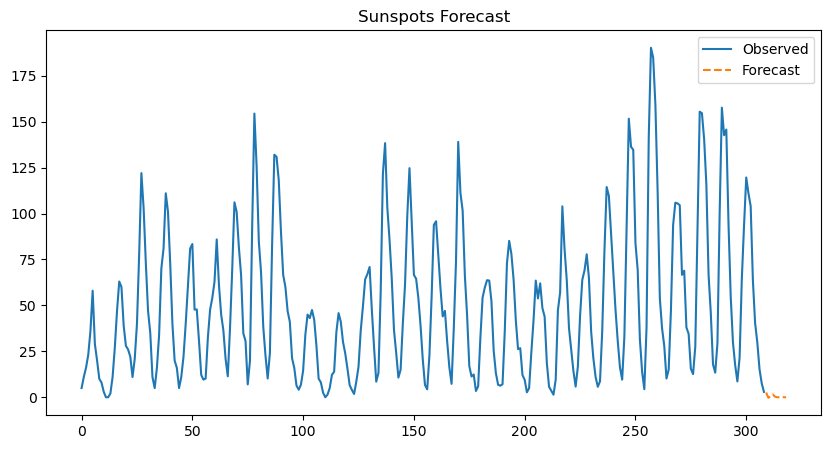

In [19]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.datasets.sunspots import load_pandas
import matplotlib.pyplot as plt


# Load the data
data = load_pandas().data['SUNACTIVITY']

# Define model parameters
q = 5

# Fit the SARIMAX model
model = SARIMAX(data, order=(0,0,q))
res = model.fit()

# Forecast the next 10 time steps
forecast = res.forecast(steps=10)

# Plot original data and forecast
data.plot(label='Observed', figsize=(10,5))
forecast.plot(label='Forecast', linestyle='--')
plt.legend()
plt.title("Sunspots Forecast")
plt.show()


### Autoregressive model – AR(p)

The autoregressive model is a regression against itself. This means that the present value depends on past values.
- Denoted as AR(p) where p is the order
- Use PACF to find p
- Assumes stationarity. Use only on stationary data

**Equation**
$$
y_t = C + \phi_1y_{t-1} + \phi_2y_{t-2} + \cdots + \phi_qy_{t-q} + \epsilon_t
$$

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29906D+00    |proj g|=  3.50363D-03

At iterate    5    f=  4.29901D+00    |proj g|=  1.71257D-03

At iterate   10    f=  4.29899D+00    |proj g|=  8.31421D-04

At iterate   15    f=  4.29897D+00    |proj g|=  3.91943D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     18      1     0     0   2.563D-05   4.299D+00
  F =   4.2989727742569404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


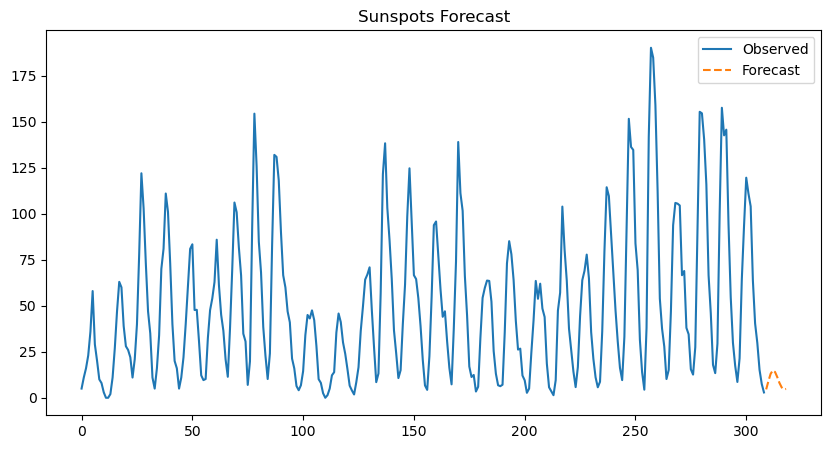

In [18]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.datasets.sunspots import load_pandas
import matplotlib.pyplot as plt


# Load the data
data = load_pandas().data['SUNACTIVITY']

# Define model parameters
p = 5

# Fit the SARIMAX model
model = SARIMAX(data, order=(p,0,0))
res = model.fit()

# Forecast the next 10 time steps
forecast = res.forecast(steps=10)

# Plot original data and forecast
data.plot(label='Observed', figsize=(10,5))
forecast.plot(label='Forecast', linestyle='--')
plt.legend()
plt.title("Sunspots Forecast")
plt.show()


### ARMA(p,q)

The autoregressive moving average model (ARMA) is the combination of the autoregressive model AR(p), and the moving average model MA(q).
- Denoted as ARMA(p,q) where p is the order of the autoregressive portion, and q is the order of the moving average portion
- Cannot use ACF or PACF to find the order p, and q. Must try different (p,q) value and select the model with the lowest AIC (Akaike’s Information Criterion)
- Assumes stationarity. Use only on stationary data.

**Equation**
$$
y_t = C + \phi_1y_{t-1} + \phi_2y_{t-2} + \cdots + \phi_qy_{t-q} + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots + \theta_q\epsilon_{t-q} + \epsilon_t
$$

/Users/robed/Documents/compass-consulting/.conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/robed/Documents/compass-consulting/.conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25241D+01    |proj g|=  1.65276D+01

At iterate    5    f=  4.40432D+00    |proj g|=  1.34756D-01

At iterate   10    f=  4.37537D+00    |proj g|=  1.35745D-01

At iterate   15    f=  4.26505D+00    |proj g|=  7.83368D-02

At iterate   20    f=  4.23097D+00    |proj g|=  2.62757D-02

At iterate   25    f=  4.21150D+00    |proj g|=  2.68233D-02

At iterate   30    f=  4.20398D+00    |proj g|=  6.96432D-02

At iterate   35    f=  4.16593D+00    |proj g|=  1.96608D-02

At iterate   40    f=  4.16171D+00    |proj g|=  1.00014D-02

At iterate   45    f=  4.16030D+00    |proj g|=  1.63870D-02

At iterate   50    f=  4.15849D+00    |proj g|=  3.06540D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/robed/Documents/compass-consulting/.conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


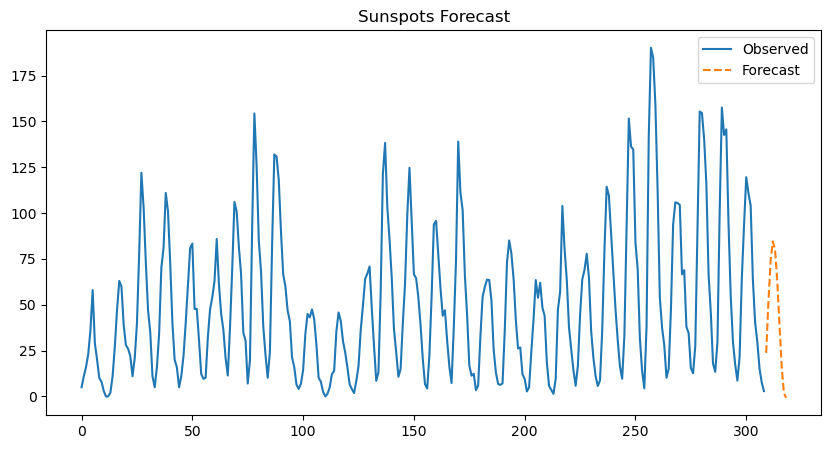

In [17]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.datasets.sunspots import load_pandas
import matplotlib.pyplot as plt


# Load the data
data = load_pandas().data['SUNACTIVITY']

# Define model parameters
p, q = 5, 3

# Fit the SARIMAX model
model = SARIMAX(data, order=(p,0,q))
res = model.fit()

# Forecast the next 10 time steps
forecast = res.forecast(steps=10)

# Plot original data and forecast
data.plot(label='Observed', figsize=(10,5))
forecast.plot(label='Forecast', linestyle='--')
plt.legend()
plt.title("Sunspots Forecast")
plt.show()


### ARIMA(p,d,q)

The autoregressive integrated moving average (ARIMA) model is the combination of the autoregressive model AR(p), and the moving average model MA(q), but in terms of the differenced series.
- Denoted as ARMA(p,d,q), where p is the order of the autoregressive portion, d is the order of integration, and q is the order of the moving average portion
- Can use on non-stationary data 

**Equation**
$$
y_t = C + \phi_1y_{t-1} + \phi_2y_{t-2} + \cdots + \phi_qy_{t-q} + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots + \theta_q\epsilon_{t-q} + \epsilon_t
$$

/Users/robed/Documents/compass-consulting/.conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/robed/Documents/compass-consulting/.conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


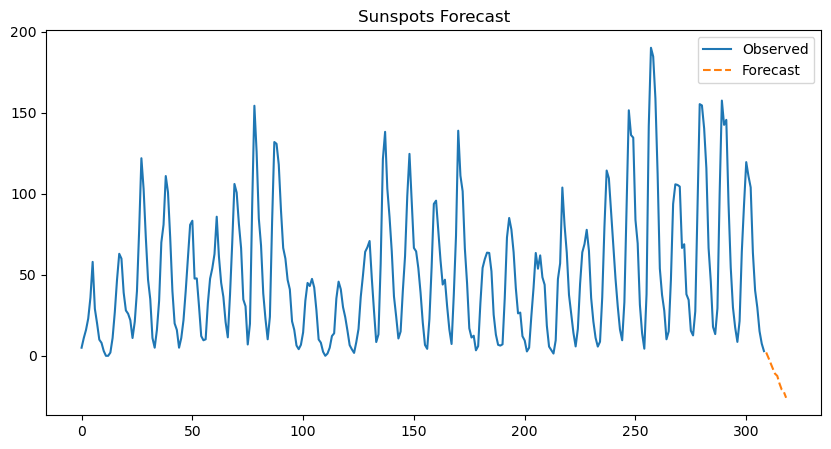

In [16]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.datasets.sunspots import load_pandas
import matplotlib.pyplot as plt


# Load the data
data = load_pandas().data['SUNACTIVITY']

# Define model parameters
p, d, q = 5, 3, 5

# Fit the SARIMAX model
model = SARIMAX(data, order=(p,d,q))
res = model.fit(disp=False)

# Forecast the next 10 time steps
forecast = res.forecast(steps=10)

# Plot original data and forecast
data.plot(label='Observed', figsize=(10,5))
forecast.plot(label='Forecast', linestyle='--')
plt.legend()
plt.title("Sunspots Forecast")
plt.show()


Note: the order of integration d is simply the number of time a series was differenced to become stationary.

### SARIMA(p,d,q)(P,D,Q)$_m$

The seasonal autoregressive integrated moving average (SARIMA) model includes a seasonal component on top of the ARIMA model.
- Denoted as SARIMA(p,d,q)(P,D,Q)m. Here, p, d, and q have the same meaning as in the ARIMA model.
- P is the seasonal order of the autoregressive portion
- D is the seasonal order of integration
- Q is the seasonal order of the moving average portion
- m is the frequency of the data (i.e., the number of data points in one season)

/Users/robed/Documents/compass-consulting/.conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/robed/Documents/compass-consulting/.conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/robed/Documents/compass-consulting/.conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


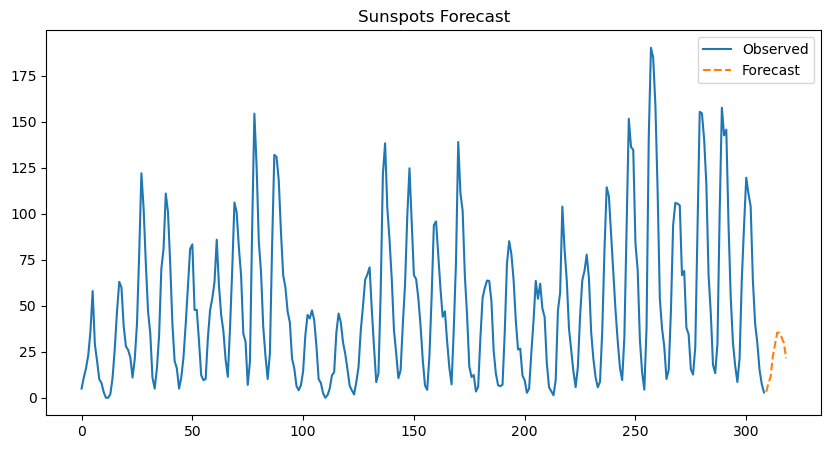

In [7]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.datasets.sunspots import load_pandas
import matplotlib.pyplot as plt



# Load the data
data = load_pandas().data['SUNACTIVITY']

# Define model parameters

# Period s is usually set based on domain knowledge about the dataset:
# For example:
#   * Weather or climate data: $ s = 12$ (12 months per year)
#   * Financial data: $ s = 4$ (4 quarters per year)
# The seasonal differencing order D is rarely greater than 1 in practice.
# The seasonal AR and MA orders P and Q are commonly less than 3.
p, d, q = 5, 3, 3
P, D, Q, m = 2, 1, 2, 12

# Fit the SARIMAX model
model = SARIMAX(data, order=(p,d,q), seasonal_order=(P,D,Q,m))
res = model.fit(disp=False)

# Forecast the next 10 time steps
forecast = res.forecast(steps=10)

# Plot original data and forecast
data.plot(label='Observed', figsize=(10,5))
forecast.plot(label='Forecast', linestyle='--')
plt.legend()
plt.title("Sunspots Forecast")
plt.show()
